In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from spektral.layers import GATConv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import logging
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time
from sklearn.utils import resample
import shutil  # For removing directories
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate, Embedding, Flatten, Layer, Lambda
from tensorflow.keras.models import Model


f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Download NLTK stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# -------------------------------
# 1. Data Preparation
# -------------------------------

# Load the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")  # Replace with your dataset path
df = df[['Text', 'Category', 'Polarity']]
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Initialize Bengali stopwords
nltk.download('stopwords')

Initial DataFrame:
                                                Text                 Category  \
0              স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।                  service   
1  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...                     food   
2  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...  anecdotes/miscellaneous   
3  খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...                     food   
4  যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...                  service   

   Polarity  
0  negative  
1  positive  
2  negative  
3  positive  
4  positive  
Initial Data Shape: (2059, 3)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load Bengali stopwords
try:
    stop_words = set(stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    if stop_words:
        words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

DataFrame after text cleaning:
                                                Text                 Category  \
0                                       স্টাফ ভয়ঙ্কর                  service   
1  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...                     food   
2  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...  anecdotes/miscellaneous   
3  খাবার একদমই ব্যতিক্রমী সক্ষম রান্নাঘর গর্বের খ...                     food   
4  গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা আপনাকে খেতে...                  service   

   Polarity  
0  negative  
1  positive  
2  negative  
3  positive  
4  positive  


In [5]:
# Upsample classes to balance the dataset
from sklearn.utils import resample

def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode labels
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

In [6]:

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    input_ids = []
    attention_masks = []
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)

# Create window-based adjacency matrices
def window_based_adjacency(sentences, window_size=2, max_len=20):
    adjacency_matrices = []
    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)
        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0
        adjacency_matrices.append(adj)
    return np.array(adjacency_matrices, dtype=np.float32)

adjacency_matrices = window_based_adjacency(df_upsampled['Text'].values, window_size=2, max_len=20)

# Define labels
labels_category = df_upsampled['Category_encoded'].values
labels_polarity = df_upsampled['Polarity_encoded'].values

# Split the data
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train_category, y_test_category, y_train_polarity, y_test_polarity = train_test_split(
    input_ids, attention_masks, adjacency_matrices, labels_category, labels_polarity, test_size=0.2, random_state=42, stratify=labels_category
)

f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 258/258 [00:02<00:00, 86.30it/s] 


# With out GNN

Initial DataFrame:
                                                Text                 Category  \
0              স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।                  service   
1  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...                     food   
2  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...  anecdotes/miscellaneous   
3  খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...                     food   
4  যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...                  service   

   Polarity  
0  negative  
1  positive  
2  negative  
3  positive  
4  positive  
Initial Data Shape: (2059, 3)
DataFrame after text cleaning:
                                                Text                 Category  \
0                                       স্টাফ ভয়ঙ্কর                  service   
1  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...                     food   
2  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...  anecdotes/miscellaneous   
3  খাবার একদমই ব্যতিক্রমী

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 258/258 [00:02<00:00, 118.81it/s]
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are ini

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                          

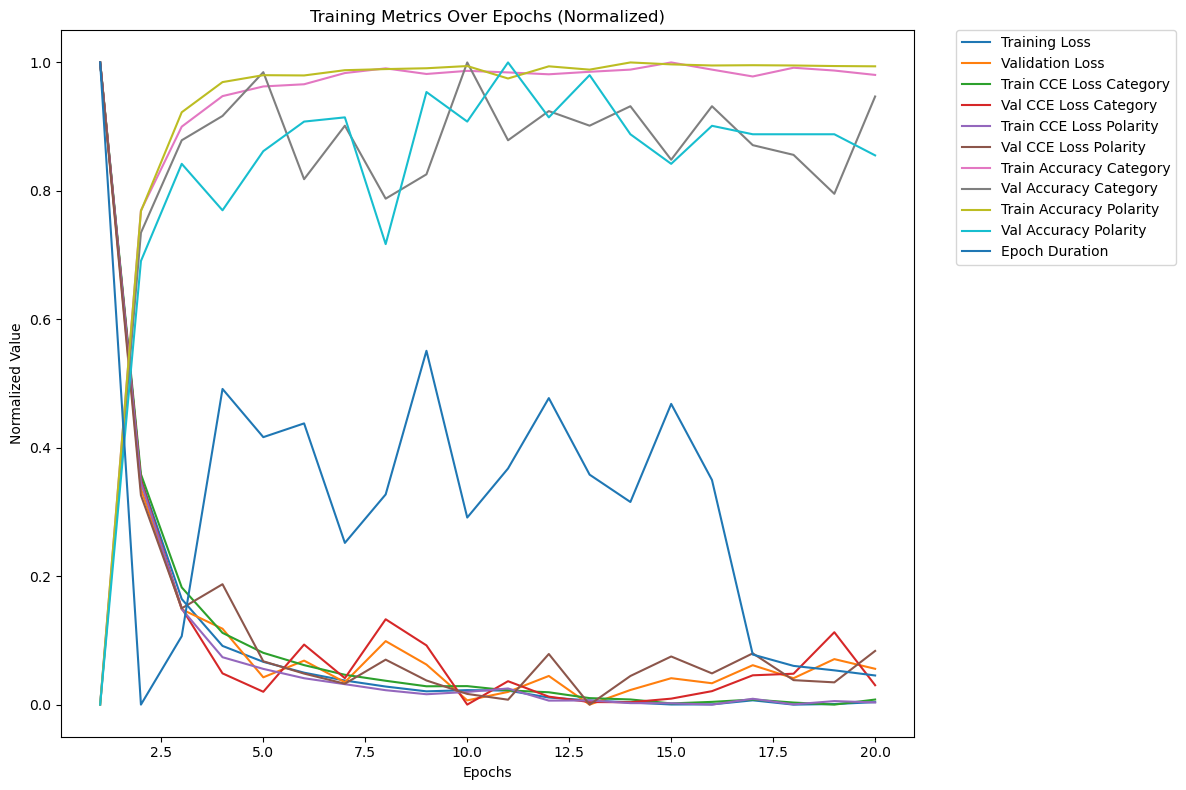

Total Training Time: 1051.47 seconds
1/1 [==============================] - 0s 68ms/step
Test Accuracy (Category): 0.9198
Test Macro F1 Score (Category): 0.9148
Test Macro Precision (Category): 0.9185
Test Macro Recall (Category): 0.9133
Test Accuracy (Polarity): 0.9611
Test Macro F1 Score (Polarity): 0.9607
Test Macro Precision (Polarity): 0.9609
Test Macro Recall (Polarity): 0.9606


<Figure size 600x600 with 0 Axes>

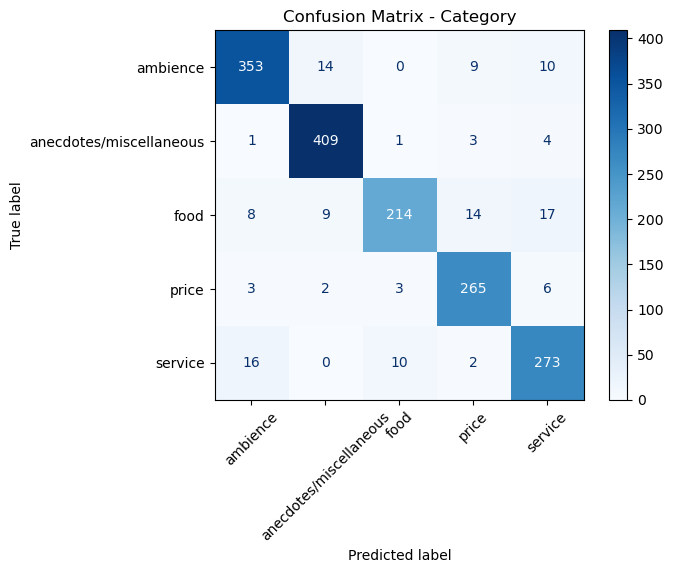

<Figure size 600x600 with 0 Axes>

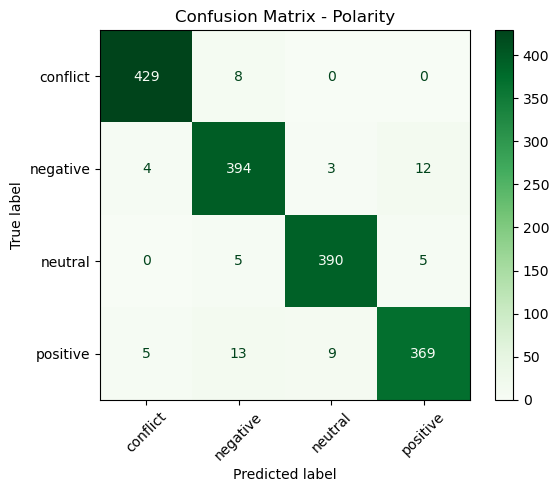

In [8]:
# sentiment_analysis_novel_without_class_weights.py

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import logging

# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Load the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")  # Replace with your dataset path
df = df[['Text', 'Category', 'Polarity']]
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Initialize Bengali stopwords
nltk.download('stopwords')

# Load Bengali stopwords
try:
    stop_words = set(stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    if stop_words:
        words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# Upsample classes to balance the dataset
from sklearn.utils import resample

def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df_upsampled_category = upsample(df, 'Category')
df_upsampled_polarity = upsample(df_upsampled_category, 'Polarity')

df_upsampled = df_upsampled_polarity.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode labels
category_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])
df_upsampled['Polarity_encoded'] = polarity_encoder.fit_transform(df_upsampled['Polarity'])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    input_ids = []
    attention_masks = []
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)

# Define labels
labels_category = df_upsampled['Category_encoded'].values
labels_polarity = df_upsampled['Polarity_encoded'].values

# Split the data
X_train_ids, X_test_ids, X_train_masks, X_test_masks, y_train_category, y_test_category, y_train_polarity, y_test_polarity = train_test_split(
    input_ids, attention_masks, labels_category, labels_polarity, test_size=0.2, random_state=42, stratify=labels_category
)

# -------------------------------
# 2. Model Architecture
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate, Flatten, Layer
from tensorflow.keras.models import Model

def squash(vectors):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    unit_vectors = vectors / tf.sqrt(s_squared_norm + 1e-9)
    return scale * unit_vectors

# Capsule Network Implementation
def build_model(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)

    # Apply Capsule Networks
    caps_num_capsules = 10  # Number of capsules
    caps_dim_capsules = 16  # Dimension of each capsule

    # Primary Capsule Layer
    primary_capsules = tf.keras.layers.Conv1D(
        filters=caps_num_capsules * caps_dim_capsules,
        kernel_size=1,
        strides=1,
        padding='valid'
    )(sequence_output)

    primary_capsules = tf.keras.layers.Reshape(
        target_shape=(max_len, caps_num_capsules, caps_dim_capsules)
    )(primary_capsules)

    primary_capsules = tf.keras.layers.Lambda(squash, name='primary_caps_squash')(primary_capsules)

    # Flatten capsules
    flat_capsules = Flatten()(primary_capsules)

    # Classification Heads for Hierarchical Multi-Task Learning
    dropout = Dropout(0.3)(flat_capsules)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Combine flat capsules and category prediction for polarity prediction
    combined_input = Concatenate()([dropout, category_output])

    # Polarity Output uses combined input
    polarity_dropout = Dropout(0.3)(combined_input)
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(polarity_dropout)

    # Include flat_capsules in outputs
    model = Model(
        inputs=[input_ids, attention_masks],
        outputs=[category_output, polarity_output, flat_capsules]
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model
model = build_model(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

# -------------------------------
# 3. Defining Custom Loss Functions and Metrics
# -------------------------------

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy()
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy()

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# -------------------------------
# 4. Custom Training Loop
# -------------------------------

@tf.function
def train_step(input_ids, attention_masks, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks], training=True)
        predictions_category = predictions[0]
        predictions_polarity = predictions[1]

        # Compute loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

        # Total loss
        total_loss = cce_loss_category + cce_loss_polarity

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

@tf.function
def test_step(input_ids, attention_masks, labels_category, labels_polarity):
    # Forward pass
    predictions = model([input_ids, attention_masks], training=False)
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    # Compute loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

    # Total loss
    total_loss = cce_loss_category + cce_loss_polarity

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 20
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)

# Import the time module
import time

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = train_step(
            input_ids, attention_masks, labels_category, labels_polarity)

        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)

        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}, "
                  f"Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = test_step(
            input_ids, attention_masks, labels_category, labels_polarity)

        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Collect all metrics to plot
    metrics_to_plot = [
        ('train_loss', 'Training Loss'),
        ('val_loss', 'Validation Loss'),
        ('train_cce_loss_category', 'Train CCE Loss Category'),
        ('val_cce_loss_category', 'Val CCE Loss Category'),
        ('train_cce_loss_polarity', 'Train CCE Loss Polarity'),
        ('val_cce_loss_polarity', 'Val CCE Loss Polarity'),
        ('train_accuracy_category', 'Train Accuracy Category'),
        ('val_accuracy_category', 'Val Accuracy Category'),
        ('train_accuracy_polarity', 'Train Accuracy Polarity'),
        ('val_accuracy_polarity', 'Val Accuracy Polarity'),
        ('epoch_time', 'Epoch Duration')
    ]

    # Normalize all metrics to 0-1 range for plotting
    normalized_metrics = {}
    for key, label in metrics_to_plot:
        data = history[key]
        min_val = min(data)
        max_val = max(data)
        if max_val - min_val == 0:
            # Avoid division by zero
            normalized_data = [0.0 for _ in data]
        else:
            normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
        normalized_metrics[label] = normalized_data

    # Plot all metrics on the same plot
    plt.figure(figsize=(12, 8))

    for label, data in normalized_metrics.items():
        plt.plot(epochs, data, label=label)

    plt.title('Training Metrics Over Epochs (Normalized)')
    plt.xlabel('Epochs')
    plt.ylabel('Normalized Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# After training is complete
plot_training_history(history)

# Display total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']

    predictions = model.predict([input_ids, attention_masks])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)
all_labels_polarity = np.array(all_labels_polarity)
all_predictions_polarity = np.array(all_predictions_polarity)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")

plt.figure(figsize=(6, 6))
# Confusion Matrix for Category
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Category')
plt.show()

plt.figure(figsize=(6, 6))
# Confusion Matrix for Polarity
cm_polarity = confusion_matrix(all_labels_polarity, all_predictions_polarity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_polarity, display_labels=polarity_encoder.classes_)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title('Confusion Matrix - Polarity')
plt.show()


remove Capsule Network

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_3 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                          

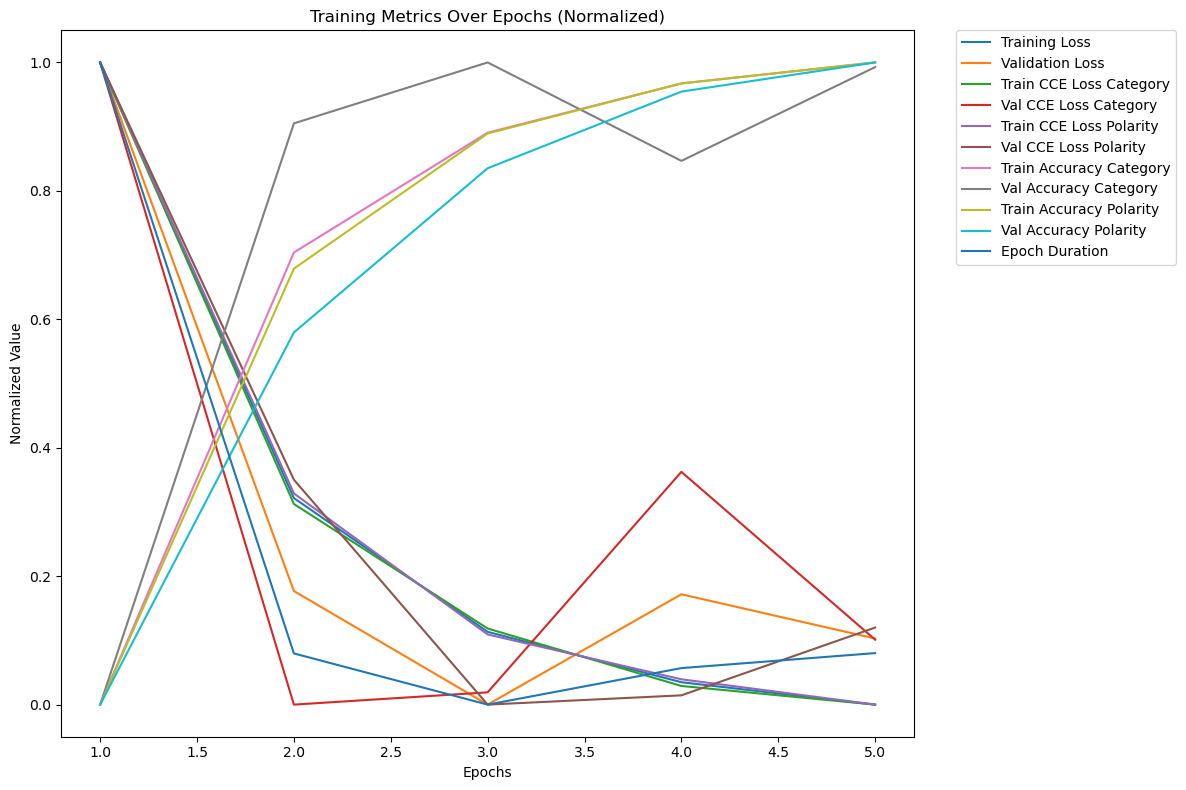

Total Training Time: 338.17 seconds
1/1 [==============================] - 0s 73ms/step
Test Accuracy (Category): 0.8979
Test Macro F1 Score (Category): 0.8904
Test Macro Precision (Category): 0.8975
Test Macro Recall (Category): 0.8879
Test Accuracy (Polarity): 0.9581
Test Macro F1 Score (Polarity): 0.9575
Test Macro Precision (Polarity): 0.9579
Test Macro Recall (Polarity): 0.9576


<Figure size 600x600 with 0 Axes>

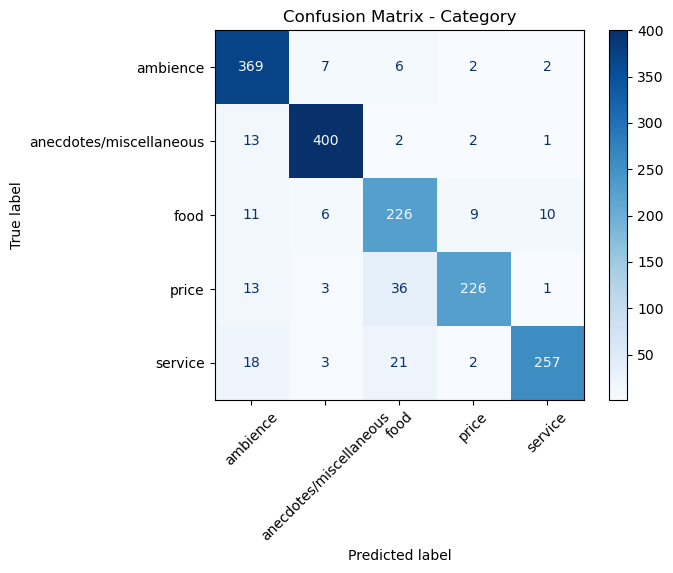

<Figure size 600x600 with 0 Axes>

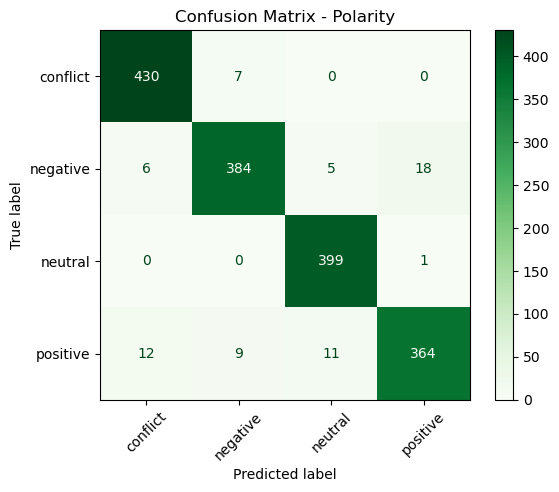

In [10]:
# -------------------------------
# 2. Model Architecture
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate, Flatten, Layer
from tensorflow.keras.models import Model
from spektral.layers import GATConv

# Removed the squash function as Capsule Networks are already removed

# Custom Multi-Head Attention Layer
class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, max_len, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        self.max_len = max_len

    def build(self, input_shape):
        if isinstance(input_shape, list) and len(input_shape) == 3:
            q_shape, k_shape, v_shape = input_shape
        else:
            q_shape = input_shape
            k_shape = input_shape
            v_shape = input_shape
        self.wq = self.add_weight(shape=(q_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wk = self.add_weight(shape=(k_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wv = self.add_weight(shape=(v_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, self.max_len, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def call(self, inputs, mask=None):
        if isinstance(inputs, list) and len(inputs) == 3:
            q, k, v = inputs
        else:
            q = inputs
            k = inputs
            v = inputs
        batch_size = tf.shape(q)[0]

        q = tf.matmul(q, self.wq)
        k = tf.matmul(k, self.wk)
        v = tf.matmul(v, self.wv)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, self.max_len, self.key_dim))

        # Set shapes for Keras
        concat_attention.set_shape((None, self.max_len, self.key_dim))
        attention_weights.set_shape((None, self.num_heads, self.max_len, self.max_len))

        return concat_attention, attention_weights

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            batch_size = input_shape[0][0]
        else:
            batch_size = input_shape[0]
        return (batch_size, self.max_len, self.key_dim)

# GNNContextResonance Layer (Retained)
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_heads=8, max_len=20, dropout_rate=0.2, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.max_len = max_len
        self.dropout_rate = dropout_rate

        # Positional Encoding
        self.position_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=hidden_size)

        # Multi-Head GAT Layers with Residual Connections
        self.gat_layers = [GATConv(hidden_size // num_heads, activation='elu') for _ in range(num_heads)]
        self.concat = Concatenate()

        # Highway Network for Modulation
        self.transform_gate = Dense(hidden_size, activation='sigmoid')
        self.carry_gate = Dense(hidden_size, activation='sigmoid')

        # Dropout and Layer Norm
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = LayerNormalization(epsilon=1e-6)

        # Dense layer for resonance scores
        self.dense = Dense(1, activation='sigmoid')

    def call(self, inputs, adjacency, edge_features=None, training=False):
        """
        inputs: BERT embeddings (batch_size, seq_length, hidden_size)
        adjacency: Adjacency matrices (batch_size, seq_length, seq_length)
        edge_features: Edge features (batch_size, seq_length, seq_length, edge_feature_dim)
        """
        # Positional Encoding
        position_indices = tf.range(self.max_len)[tf.newaxis, :]
        position_embeddings = self.position_embedding(position_indices)
        inputs = inputs + position_embeddings

        # Multi-Head GAT
        gat_outputs = []
        for gat_layer in self.gat_layers:
            x = gat_layer([inputs, adjacency])
            gat_outputs.append(x)
        x = self.concat(gat_outputs)  # Concatenate outputs from all heads

        # Residual Connection
        x = x + inputs  # Residual connection

        # Highway Network for Modulation
        transform = self.transform_gate(x)
        carry = self.carry_gate(inputs)
        outputs = transform * x + (1 - transform) * carry

        # Apply dropout and layer normalization
        outputs = self.dropout(outputs, training=training)
        outputs = self.layer_norm(outputs)

        # Compute resonance scores
        resonance_scores = self.dense(outputs)

        return outputs, resonance_scores

def build_model_with_gnn(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)

    # Apply GNN-Based ContextResonance
    gnn_resonance_layer = GNNContextResonance(hidden_size, num_heads=8, max_len=max_len)
    gnn_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)

    # Implement Dual Attention Mechanism
    # Self-attention over GNN outputs
    self_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    self_attention_output, self_attention_scores = self_attention_layer([gnn_output, gnn_output, gnn_output])

    # Cross-attention between BERT outputs and GNN outputs
    cross_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    cross_attention_output, cross_attention_scores = cross_attention_layer([sequence_output, gnn_output, gnn_output])

    # Combine outputs
    combined_output = Concatenate(axis=-1)([self_attention_output, cross_attention_output])

    # Removed Capsule Network Layers

    # Aggregate token embeddings to a single vector (using [CLS] token)
    cls_embedding = combined_output[:, 0, :]  # Assuming [CLS] is the first token

    # Classification Heads for Hierarchical Multi-Task Learning
    dropout = Dropout(0.3)(cls_embedding)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Combine for Polarity Output
    combined_input = Concatenate()([dropout, category_output])

    # Polarity Output uses combined input
    polarity_dropout = Dropout(0.3)(combined_input)
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(polarity_dropout)

    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[category_output, polarity_output]
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

# -------------------------------
# 3. Defining Custom Loss Functions and Metrics
# -------------------------------

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions with 'mean' reduction
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO)
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# -------------------------------
# 4. Custom Training Loop
# -------------------------------

@tf.function
def train_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks, adjacency], training=True)
        predictions_category = predictions[0]
        predictions_polarity = predictions[1]

        # Compute loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

        # Total loss
        total_loss = cce_loss_category + cce_loss_polarity

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    # Forward pass
    predictions = model([input_ids, attention_masks, adjacency], training=False)
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    # Compute loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

    # Total loss
    total_loss = cce_loss_category + cce_loss_polarity

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 5  # Reduced epochs for demonstration; adjust as needed
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks,
        'adjacency': adjacency_train
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks,
        'adjacency': adjacency_test
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)

# Import the time module
import time

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = train_step(
            input_ids, attention_masks, adjacency, labels_category, labels_polarity)

        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)

        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}, "
                  f"Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = test_step(
            input_ids, attention_masks, adjacency, labels_category, labels_polarity)

        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Collect all metrics to plot
    metrics_to_plot = [
        ('train_loss', 'Training Loss'),
        ('val_loss', 'Validation Loss'),
        ('train_cce_loss_category', 'Train CCE Loss Category'),
        ('val_cce_loss_category', 'Val CCE Loss Category'),
        ('train_cce_loss_polarity', 'Train CCE Loss Polarity'),
        ('val_cce_loss_polarity', 'Val CCE Loss Polarity'),
        ('train_accuracy_category', 'Train Accuracy Category'),
        ('val_accuracy_category', 'Val Accuracy Category'),
        ('train_accuracy_polarity', 'Train Accuracy Polarity'),
        ('val_accuracy_polarity', 'Val Accuracy Polarity'),
        ('epoch_time', 'Epoch Duration')
    ]

    # Normalize all metrics to 0-1 range for plotting
    normalized_metrics = {}
    for key, label in metrics_to_plot:
        data = history[key]
        min_val = min(data)
        max_val = max(data)
        if max_val - min_val == 0:
            # Avoid division by zero
            normalized_data = [0.0 for _ in data]
        else:
            normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
        normalized_metrics[label] = normalized_data

    # Plot all metrics on the same plot
    plt.figure(figsize=(12, 8))

    for label, data in normalized_metrics.items():
        plt.plot(epochs, data, label=label)

    plt.title('Training Metrics Over Epochs (Normalized)')
    plt.xlabel('Epochs')
    plt.ylabel('Normalized Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# After training is complete
plot_training_history(history)

# Display total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']

    predictions = model.predict([input_ids, attention_masks, adjacency])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)
all_labels_polarity = np.array(all_labels_polarity)
all_predictions_polarity = np.array(all_predictions_polarity)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")

plt.figure(figsize=(6, 6))
# Confusion Matrix for Category
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Category')
plt.show()

plt.figure(figsize=(6, 6))
# Confusion Matrix for Polarity
cm_polarity = confusion_matrix(all_labels_polarity, all_predictions_polarity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_polarity, display_labels=polarity_encoder.classes_)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title('Confusion Matrix - Polarity')
plt.show()

 without smoothness loss 

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_5 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                          

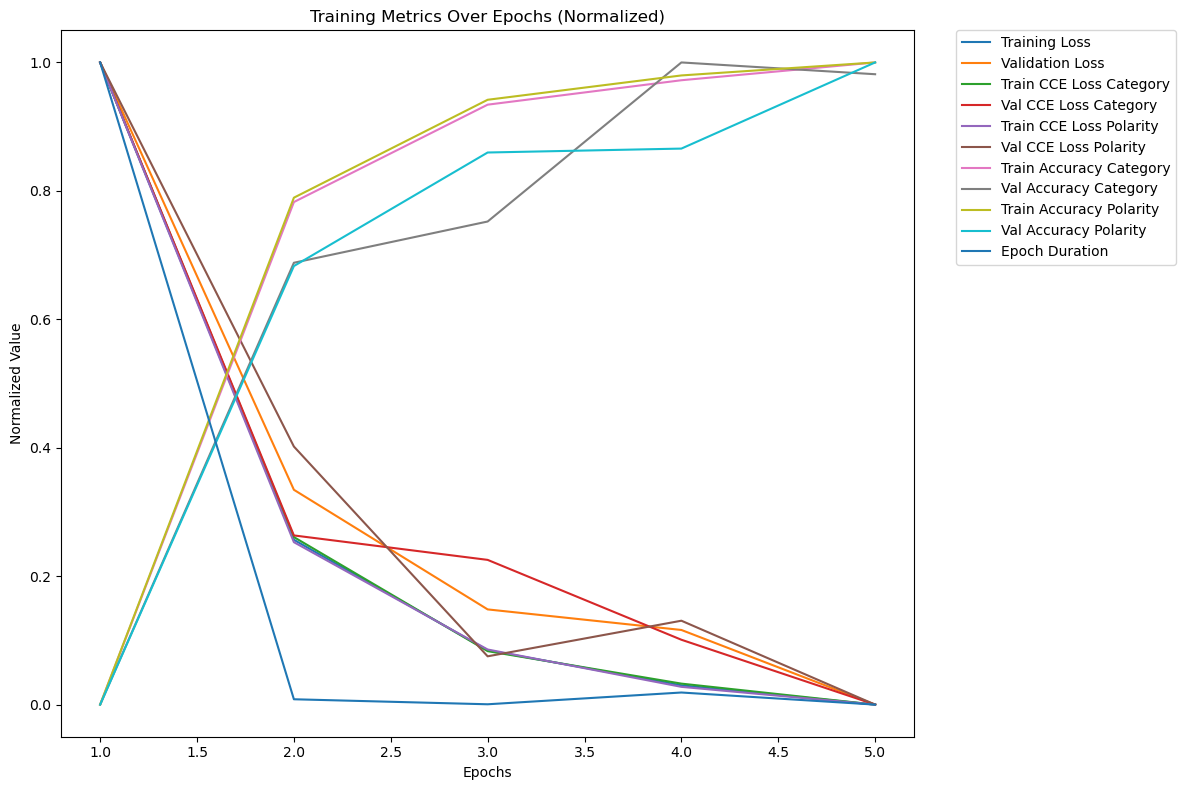

Total Training Time: 249.31 seconds
1/1 [==============================] - 0s 63ms/step
Test Accuracy (Category): 0.9125
Test Macro F1 Score (Category): 0.9072
Test Macro Precision (Category): 0.9109
Test Macro Recall (Category): 0.9050
Test Accuracy (Polarity): 0.9684
Test Macro F1 Score (Polarity): 0.9681
Test Macro Precision (Polarity): 0.9681
Test Macro Recall (Polarity): 0.9682


<Figure size 600x600 with 0 Axes>

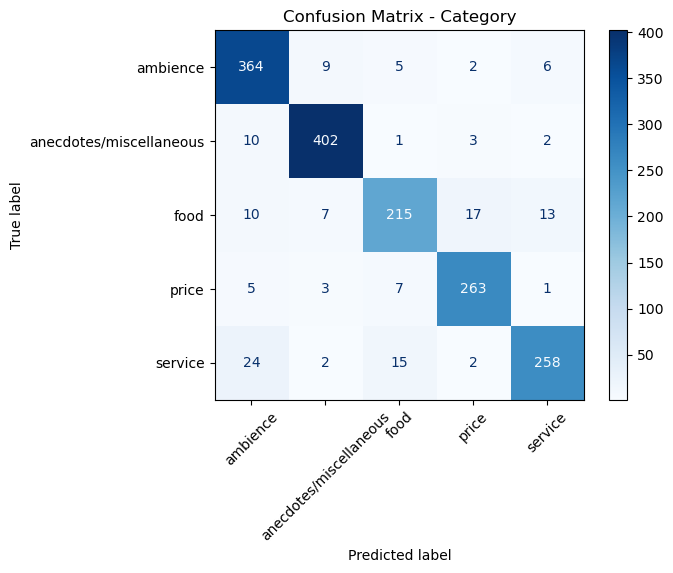

<Figure size 600x600 with 0 Axes>

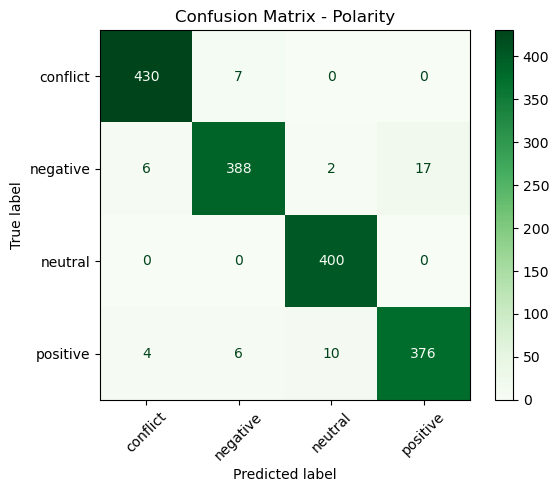

In [12]:

# -------------------------------
# 2. Model Architecture
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate, Flatten, Layer
from tensorflow.keras.models import Model

# Custom Multi-Head Attention Layer (Retained if needed)
class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, max_len, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        self.max_len = max_len

    def build(self, input_shape):
        if isinstance(input_shape, list) and len(input_shape) == 3:
            q_shape, k_shape, v_shape = input_shape
        else:
            q_shape = input_shape
            k_shape = input_shape
            v_shape = input_shape
        self.wq = self.add_weight(shape=(q_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wk = self.add_weight(shape=(k_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wv = self.add_weight(shape=(v_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, self.max_len, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def call(self, inputs, mask=None):
        if isinstance(inputs, list) and len(inputs) == 3:
            q, k, v = inputs
        else:
            q = inputs
            k = inputs
            v = inputs
        batch_size = tf.shape(q)[0]

        q = tf.matmul(q, self.wq)
        k = tf.matmul(k, self.wk)
        v = tf.matmul(v, self.wv)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, self.max_len, self.key_dim))

        # Set shapes for Keras
        concat_attention.set_shape((None, self.max_len, self.key_dim))
        attention_weights.set_shape((None, self.num_heads, self.max_len, self.max_len))

        return concat_attention, attention_weights

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            batch_size = input_shape[0][0]
        else:
            batch_size = input_shape[0]
        return (batch_size, self.max_len, self.key_dim)

def build_model_no_gnn_capsule(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)

    # Aggregate token embeddings to a single vector (using [CLS] token)
    cls_embedding = sequence_output[:, 0, :]  # [CLS] token is the first token

    # Classification Heads for Hierarchical Multi-Task Learning
    dropout = Dropout(0.3)(cls_embedding)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Combine for Polarity Output
    combined_input = Concatenate()([dropout, category_output])

    # Polarity Output uses combined input
    polarity_dropout = Dropout(0.3)(combined_input)
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(polarity_dropout)

    model = Model(
        inputs=[input_ids, attention_masks],
        outputs=[category_output, polarity_output]
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model
model = build_model_no_gnn_capsule(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

# -------------------------------
# 3. Defining Custom Loss Functions and Metrics
# -------------------------------

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions with 'mean' reduction
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO)
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# -------------------------------
# 4. Custom Training Loop
# -------------------------------

@tf.function
def train_step_final(input_ids, attention_masks, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks], training=True)
        predictions_category = predictions[0]
        predictions_polarity = predictions[1]

        # Compute loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

        # Total loss
        total_loss = cce_loss_category + cce_loss_polarity

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

@tf.function
def test_step_final(input_ids, attention_masks, labels_category, labels_polarity):
    # Forward pass
    predictions = model([input_ids, attention_masks], training=False)
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    # Compute loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

    # Total loss
    total_loss = cce_loss_category + cce_loss_polarity

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 5  # Reduced epochs for demonstration; adjust as needed
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)

# Import the time module
import time

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = train_step_final(
            input_ids, attention_masks, labels_category, labels_polarity)

        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)

        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}, "
                  f"Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = test_step_final(
            input_ids, attention_masks, labels_category, labels_polarity)

        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Collect all metrics to plot
    metrics_to_plot = [
        ('train_loss', 'Training Loss'),
        ('val_loss', 'Validation Loss'),
        ('train_cce_loss_category', 'Train CCE Loss Category'),
        ('val_cce_loss_category', 'Val CCE Loss Category'),
        ('train_cce_loss_polarity', 'Train CCE Loss Polarity'),
        ('val_cce_loss_polarity', 'Val CCE Loss Polarity'),
        ('train_accuracy_category', 'Train Accuracy Category'),
        ('val_accuracy_category', 'Val Accuracy Category'),
        ('train_accuracy_polarity', 'Train Accuracy Polarity'),
        ('val_accuracy_polarity', 'Val Accuracy Polarity'),
        ('epoch_time', 'Epoch Duration')
    ]

    # Normalize all metrics to 0-1 range for plotting
    normalized_metrics = {}
    for key, label in metrics_to_plot:
        data = history[key]
        min_val = min(data)
        max_val = max(data)
        if max_val - min_val == 0:
            # Avoid division by zero
            normalized_data = [0.0 for _ in data]
        else:
            normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
        normalized_metrics[label] = normalized_data

    # Plot all metrics on the same plot
    plt.figure(figsize=(12, 8))

    for label, data in normalized_metrics.items():
        plt.plot(epochs, data, label=label)

    plt.title('Training Metrics Over Epochs (Normalized)')
    plt.xlabel('Epochs')
    plt.ylabel('Normalized Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# After training is complete
plot_training_history(history)

# Display total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']

    predictions = model.predict([input_ids, attention_masks])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)
all_labels_polarity = np.array(all_labels_polarity)
all_predictions_polarity = np.array(all_predictions_polarity)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")

plt.figure(figsize=(6, 6))
# Confusion Matrix for Category
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Category')
plt.show()

plt.figure(figsize=(6, 6))
# Confusion Matrix for Polarity
cm_polarity = confusion_matrix(all_labels_polarity, all_predictions_polarity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_polarity, display_labels=polarity_encoder.classes_)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title('Confusion Matrix - Polarity')
plt.show()

without Constrastive loss

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_9 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                          

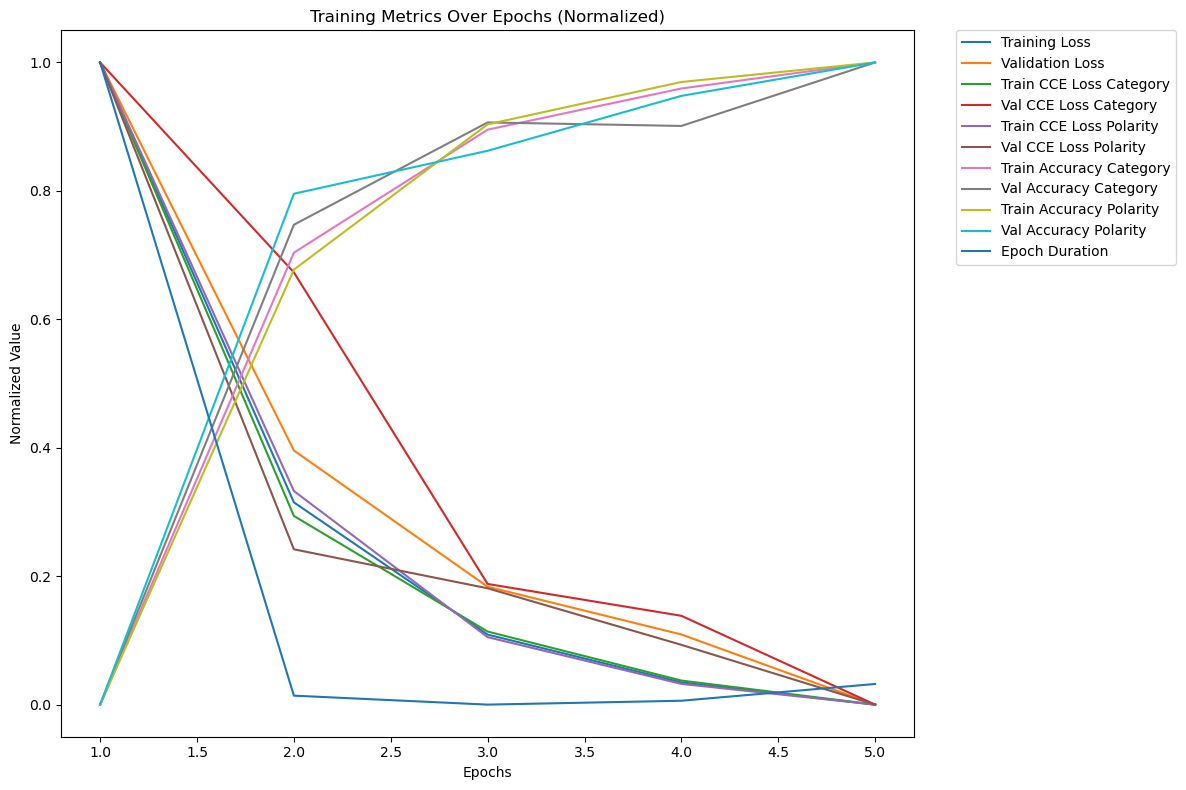

Total Training Time: 280.99 seconds
1/1 [==============================] - 0s 72ms/step
Test Accuracy (Category): 0.9137
Test Macro F1 Score (Category): 0.9074
Test Macro Precision (Category): 0.9133
Test Macro Recall (Category): 0.9045
Test Accuracy (Polarity): 0.9617
Test Macro F1 Score (Polarity): 0.9612
Test Macro Precision (Polarity): 0.9619
Test Macro Recall (Polarity): 0.9612


<Figure size 600x600 with 0 Axes>

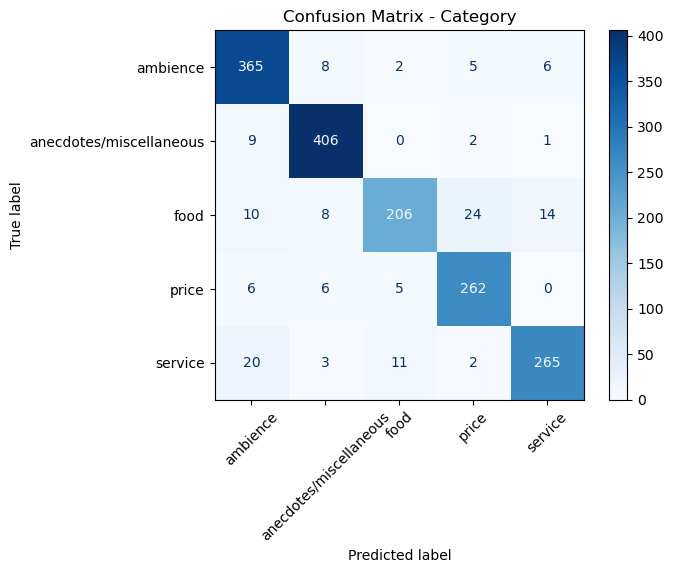

<Figure size 600x600 with 0 Axes>

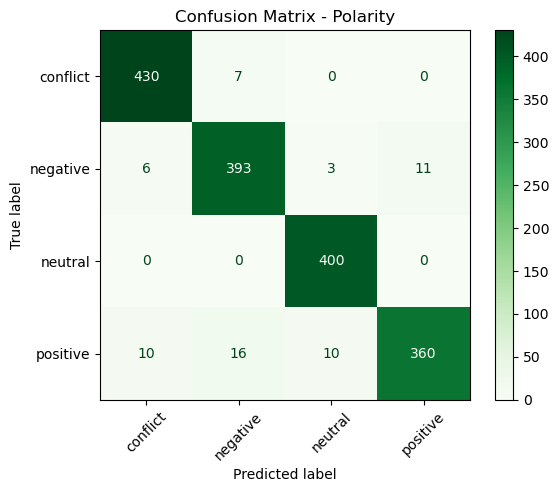

In [16]:
# sentiment_analysis_novel_final.py
# -------------------------------
# 2. Model Architecture
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate, Flatten, Layer, Lambda
from tensorflow.keras.models import Model
from spektral.layers import GATConv
import tensorflow as tf

# Removed the squash function as Capsule Networks are already removed

# Custom Multi-Head Attention Layer
class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, max_len, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        self.max_len = max_len

    def build(self, input_shape):
        if isinstance(input_shape, list) and len(input_shape) == 3:
            q_shape, k_shape, v_shape = input_shape
        else:
            q_shape = input_shape
            k_shape = input_shape
            v_shape = input_shape
        self.wq = self.add_weight(shape=(q_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wk = self.add_weight(shape=(k_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wv = self.add_weight(shape=(v_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, self.max_len, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def call(self, inputs, mask=None):
        if isinstance(inputs, list) and len(inputs) == 3:
            q, k, v = inputs
        else:
            q = inputs
            k = inputs
            v = inputs
        batch_size = tf.shape(q)[0]

        q = tf.matmul(q, self.wq)
        k = tf.matmul(k, self.wk)
        v = tf.matmul(v, self.wv)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, self.max_len, self.key_dim))

        # Set shapes for Keras
        concat_attention.set_shape((None, self.max_len, self.key_dim))
        attention_weights.set_shape((None, self.num_heads, self.max_len, self.max_len))

        return concat_attention, attention_weights

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            batch_size = input_shape[0][0]
        else:
            batch_size = input_shape[0]
        return (batch_size, self.max_len, self.key_dim)

# GNNContextResonance Layer without Smoothness Loss
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_heads=8, max_len=20, dropout_rate=0.2, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.max_len = max_len
        self.dropout_rate = dropout_rate

        # Positional Encoding
        self.position_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=hidden_size)

        # Multi-Head GAT Layers with Residual Connections
        self.gat_layers = [GATConv(hidden_size // num_heads, activation='elu') for _ in range(num_heads)]
        self.concat = Concatenate()

        # Highway Network for Modulation
        self.transform_gate = Dense(hidden_size, activation='sigmoid')
        self.carry_gate = Dense(hidden_size, activation='sigmoid')

        # Dropout and Layer Norm
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = LayerNormalization(epsilon=1e-6)

        # Removed dense layer for resonance scores

    def call(self, inputs, adjacency, edge_features=None, training=False):
        """
        inputs: BERT embeddings (batch_size, seq_length, hidden_size)
        adjacency: Adjacency matrices (batch_size, seq_length, seq_length)
        edge_features: Edge features (batch_size, seq_length, seq_length, edge_feature_dim)
        """
        # Positional Encoding
        position_indices = tf.range(self.max_len)[tf.newaxis, :]
        position_embeddings = self.position_embedding(position_indices)
        inputs = inputs + position_embeddings

        # Multi-Head GAT
        gat_outputs = []
        for gat_layer in self.gat_layers:
            x = gat_layer([inputs, adjacency])
            gat_outputs.append(x)
        x = self.concat(gat_outputs)  # Concatenate outputs from all heads

        # Residual Connection
        x = x + inputs  # Residual connection

        # Highway Network for Modulation
        transform = self.transform_gate(x)
        carry = self.carry_gate(inputs)
        outputs = transform * x + (1 - transform) * carry

        # Apply dropout and layer normalization
        outputs = self.dropout(outputs, training=training)
        outputs = self.layer_norm(outputs)

        return outputs  # Removed resonance_scores from outputs

def supervised_contrastive_loss(labels, features, temperature=0.1):
    labels = tf.reshape(labels, [-1])
    label_mask = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    features = tf.math.l2_normalize(features, axis=1)
    similarity_matrix = tf.matmul(features, features, transpose_b=True) / temperature
    logits_max = tf.reduce_max(similarity_matrix, axis=1, keepdims=True)
    logits = similarity_matrix - logits_max
    exp_logits = tf.exp(logits) * tf.cast(label_mask, tf.float32)
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-8)
    mean_log_prob_pos = tf.reduce_sum(log_prob * tf.cast(label_mask, tf.float32), axis=1) / tf.reduce_sum(tf.cast(label_mask, tf.float32), axis=1)
    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss

def build_model_with_cls(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)

    # Apply GNN-Based ContextResonance
    gnn_resonance_layer = GNNContextResonance(hidden_size, num_heads=8, max_len=max_len)
    gnn_output = gnn_resonance_layer(sequence_output, adjacency)

    # Implement Dual Attention Mechanism
    # Self-attention over GNN outputs
    self_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    self_attention_output, _ = self_attention_layer([gnn_output, gnn_output, gnn_output])

    # Cross-attention between BERT outputs and GNN outputs
    cross_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    cross_attention_output, _ = cross_attention_layer([sequence_output, gnn_output, gnn_output])

    # Combine outputs
    combined_output = Concatenate(axis=-1)([self_attention_output, cross_attention_output])

    # Aggregate token embeddings to a single vector using [CLS] token
    cls_embedding = Lambda(lambda x: x[:, 0, :])(combined_output)  # (batch_size, combined_dimension)

    # Classification Heads for Hierarchical Multi-Task Learning
    dropout = Dropout(0.3)(cls_embedding)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Combine for Polarity Output
    combined_input = Concatenate()([dropout, category_output])

    # Polarity Output uses combined input
    polarity_dropout = Dropout(0.3)(combined_input)
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(polarity_dropout)

    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[category_output, polarity_output]
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model using the updated function
model = build_model_with_cls(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

# -------------------------------
# 3. Defining Custom Loss Functions and Metrics
# -------------------------------

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions with 'mean' reduction
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO)
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# -------------------------------
# 4. Custom Training Loop
# -------------------------------

@tf.function
def train_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks, adjacency], training=True)
        predictions_category = predictions[0]  # Shape: (batch_size, num_category_classes)
        predictions_polarity = predictions[1]  # Shape: (batch_size, num_polarity_classes)

        # Compute loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

        # Total loss
        total_loss = cce_loss_category + cce_loss_polarity

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels_category, labels_polarity):
    # Forward pass
    predictions = model([input_ids, attention_masks, adjacency], training=False)
    predictions_category = predictions[0]  # Shape: (batch_size, num_category_classes)
    predictions_polarity = predictions[1]  # Shape: (batch_size, num_polarity_classes)

    # Compute loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

    # Total loss
    total_loss = cce_loss_category + cce_loss_polarity

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 5
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks,
        'adjacency': adjacency_train
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks,
        'adjacency': adjacency_test
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)

# Import the time module
import time

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = train_step(
            input_ids, attention_masks, adjacency, labels_category, labels_polarity)

        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)

        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}, "
                  f"Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = test_step(
            input_ids, attention_masks, adjacency, labels_category, labels_polarity)

        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Collect all metrics to plot
    metrics_to_plot = [
        ('train_loss', 'Training Loss'),
        ('val_loss', 'Validation Loss'),
        ('train_cce_loss_category', 'Train CCE Loss Category'),
        ('val_cce_loss_category', 'Val CCE Loss Category'),
        ('train_cce_loss_polarity', 'Train CCE Loss Polarity'),
        ('val_cce_loss_polarity', 'Val CCE Loss Polarity'),
        ('train_accuracy_category', 'Train Accuracy Category'),
        ('val_accuracy_category', 'Val Accuracy Category'),
        ('train_accuracy_polarity', 'Train Accuracy Polarity'),
        ('val_accuracy_polarity', 'Val Accuracy Polarity'),
        ('epoch_time', 'Epoch Duration')
    ]

    # Normalize all metrics to 0-1 range for plotting
    normalized_metrics = {}
    for key, label in metrics_to_plot:
        data = history[key]
        min_val = min(data)
        max_val = max(data)
        if max_val - min_val == 0:
            # Avoid division by zero
            normalized_data = [0.0 for _ in data]
        else:
            normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
        normalized_metrics[label] = normalized_data

    # Plot all metrics on the same plot
    plt.figure(figsize=(12, 8))

    for label, data in normalized_metrics.items():
        plt.plot(epochs, data, label=label)

    plt.title('Training Metrics Over Epochs (Normalized)')
    plt.xlabel('Epochs')
    plt.ylabel('Normalized Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# After training is complete
plot_training_history(history)

# Display total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']

    predictions = model.predict([input_ids, attention_masks, adjacency])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)
all_labels_polarity = np.array(all_labels_polarity)
all_predictions_polarity = np.array(all_predictions_polarity)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")

# Plot Confusion Matrix for Category
plt.figure(figsize=(6, 6))
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Category')
plt.show()

# Plot Confusion Matrix for Polarity
plt.figure(figsize=(6, 6))
cm_polarity = confusion_matrix(all_labels_polarity, all_predictions_polarity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_polarity, display_labels=polarity_encoder.classes_)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title('Confusion Matrix - Polarity')
plt.show()


both GNN and Capsule Network out

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_10 (TFBertModel)  TFBaseModelOutputWi  177853440  ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                         

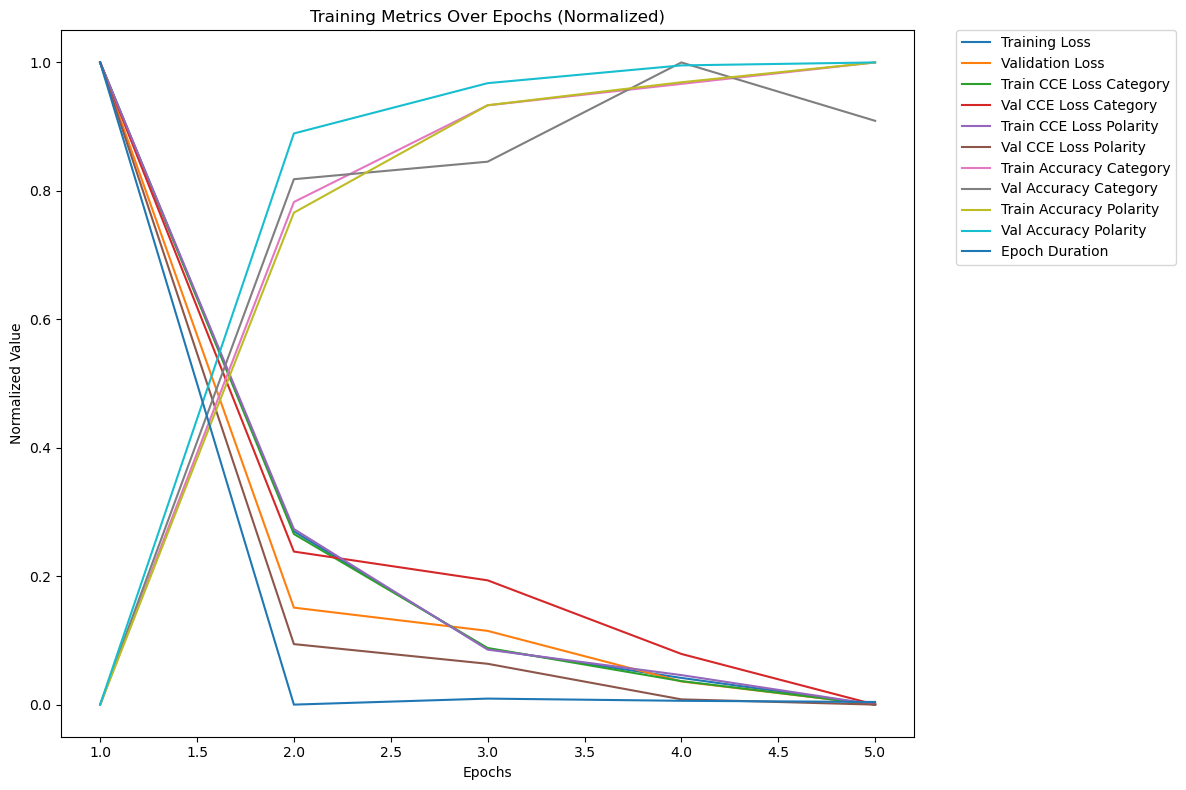

Total Training Time: 244.19 seconds


In [18]:
# sentiment_analysis_novel_final.py
# -------------------------------
# 2. Model Architecture
# -------------------------------

from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Lambda
from tensorflow.keras.models import Model
from transformers import TFBertModel
import tensorflow as tf

# Custom Multi-Head Attention Layer (Retained if needed)
class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, max_len, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        self.max_len = max_len

    def build(self, input_shape):
        if isinstance(input_shape, list) and len(input_shape) == 3:
            q_shape, k_shape, v_shape = input_shape
        else:
            q_shape = input_shape
            k_shape = input_shape
            v_shape = input_shape
        self.wq = self.add_weight(shape=(q_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wk = self.add_weight(shape=(k_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wv = self.add_weight(shape=(v_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, self.max_len, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def call(self, inputs, mask=None):
        if isinstance(inputs, list) and len(inputs) == 3:
            q, k, v = inputs
        else:
            q = inputs
            k = inputs
            v = inputs
        batch_size = tf.shape(q)[0]

        q = tf.matmul(q, self.wq)
        k = tf.matmul(k, self.wk)
        v = tf.matmul(v, self.wv)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, self.max_len, self.key_dim))

        # Set shapes for Keras
        concat_attention.set_shape((None, self.max_len, self.key_dim))
        attention_weights.set_shape((None, self.num_heads, self.max_len, self.max_len))

        return concat_attention, attention_weights

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            batch_size = input_shape[0][0]
        else:
            batch_size = input_shape[0]
        return (batch_size, self.max_len, self.key_dim)

def build_model_no_gnn_capsule(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)

    # Extract the [CLS] token embedding
    cls_embedding = Lambda(lambda x: x[:, 0, :])(sequence_output)  # (batch_size, hidden_size)

    # Apply Dropout
    dropout = Dropout(0.3)(cls_embedding)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Combine for Polarity Output
    combined_input = Concatenate()([dropout, category_output])

    # Polarity Output uses combined input
    polarity_dropout = Dropout(0.3)(combined_input)
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(polarity_dropout)

    model = Model(
        inputs=[input_ids, attention_masks],
        outputs=[category_output, polarity_output]
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model using the updated function
model = build_model_no_gnn_capsule(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

# -------------------------------
# 3. Defining Custom Loss Functions and Metrics
# -------------------------------

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss functions with 'mean' reduction
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO)
loss_fn_polarity = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.AUTO)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
train_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_polarity')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')
val_accuracy_polarity = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_polarity')

# -------------------------------
# 4. Custom Training Loop
# -------------------------------

@tf.function
def train_step(input_ids, attention_masks, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks], training=True)
        predictions_category = predictions[0]  # Shape: (batch_size, num_category_classes)
        predictions_polarity = predictions[1]  # Shape: (batch_size, num_polarity_classes)

        # Compute loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

        # Total loss
        total_loss = cce_loss_category + cce_loss_polarity

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

@tf.function
def test_step(input_ids, attention_masks, labels_category, labels_polarity):
    # Forward pass
    predictions = model([input_ids, attention_masks], training=False)
    predictions_category = predictions[0]  # Shape: (batch_size, num_category_classes)
    predictions_polarity = predictions[1]  # Shape: (batch_size, num_polarity_classes)

    # Compute loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

    # Total loss
    total_loss = cce_loss_category + cce_loss_polarity

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 5
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)

# Import the time module
import time

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = train_step(
            input_ids, attention_masks, labels_category, labels_polarity)

        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)

        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}, "
                  f"Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = test_step(
            input_ids, attention_masks, labels_category, labels_polarity)

        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Collect all metrics to plot
    metrics_to_plot = [
        ('train_loss', 'Training Loss'),
        ('val_loss', 'Validation Loss'),
        ('train_cce_loss_category', 'Train CCE Loss Category'),
        ('val_cce_loss_category', 'Val CCE Loss Category'),
        ('train_cce_loss_polarity', 'Train CCE Loss Polarity'),
        ('val_cce_loss_polarity', 'Val CCE Loss Polarity'),
        ('train_accuracy_category', 'Train Accuracy Category'),
        ('val_accuracy_category', 'Val Accuracy Category'),
        ('train_accuracy_polarity', 'Train Accuracy Polarity'),
        ('val_accuracy_polarity', 'Val Accuracy Polarity'),
        ('epoch_time', 'Epoch Duration')
    ]

    # Normalize all metrics to 0-1 range for plotting
    normalized_metrics = {}
    for key, label in metrics_to_plot:
        data = history[key]
        min_val = min(data)
        max_val = max(data)
        if max_val - min_val == 0:
            # Avoid division by zero
            normalized_data = [0.0 for _ in data]
        else:
            normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
        normalized_metrics[label] = normalized_data

    # Plot all metrics on the same plot
    plt.figure(figsize=(12, 8))

    for label, data in normalized_metrics.items():
        plt.plot(epochs, data, label=label)

    plt.title('Training Metrics Over Epochs (Normalized)')
    plt.xlabel('Epochs')
    plt.ylabel('Normalized Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# After training is complete
plot_training_history(history)

# Display total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")


1/1 [==============================] - 0s 56ms/step
Test Accuracy (Category): 0.9064
Test Macro F1 Score (Category): 0.8997
Test Macro Precision (Category): 0.9017
Test Macro Recall (Category): 0.8985
Test Accuracy (Polarity): 0.9587
Test Macro F1 Score (Polarity): 0.9580
Test Macro Precision (Polarity): 0.9584
Test Macro Recall (Polarity): 0.9581


<Figure size 600x600 with 0 Axes>

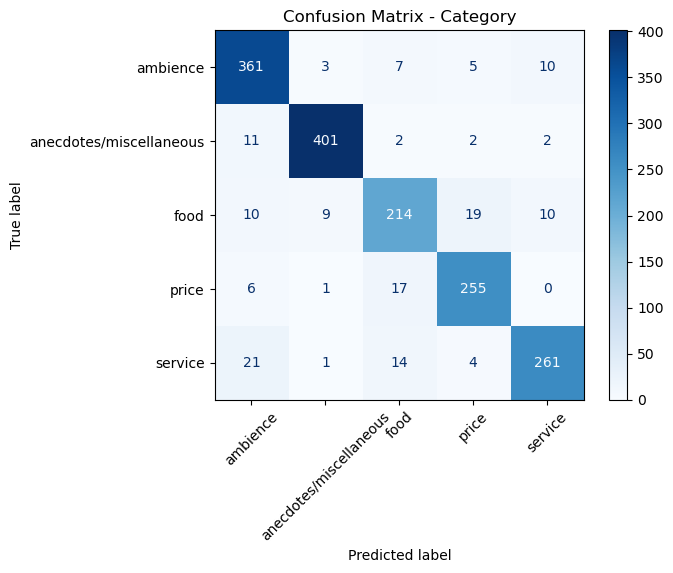

<Figure size 600x600 with 0 Axes>

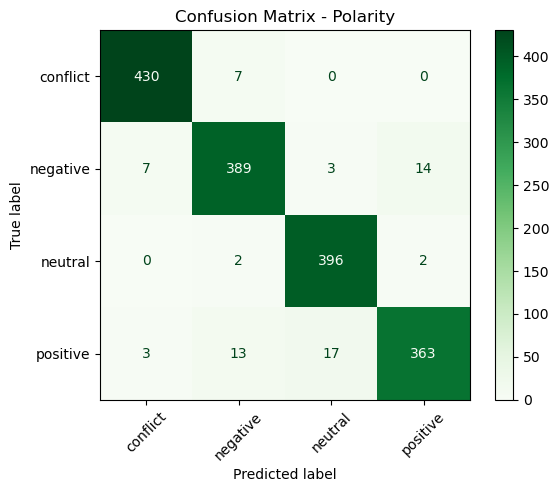

In [19]:
# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']

    predictions = model.predict([input_ids, attention_masks])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)
all_labels_polarity = np.array(all_labels_polarity)
all_predictions_polarity = np.array(all_predictions_polarity)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")

# Plot Confusion Matrix for Category
plt.figure(figsize=(6, 6))
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Category')
plt.show()

# Plot Confusion Matrix for Polarity
plt.figure(figsize=(6, 6))
cm_polarity = confusion_matrix(all_labels_polarity, all_predictions_polarity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_polarity, display_labels=polarity_encoder.classes_)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title('Confusion Matrix - Polarity')
plt.show()


# Without Both Contrastive Loss and GNN and Capsule Network

In [21]:
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Lambda
from tensorflow.keras.models import Model
from transformers import TFBertModel
import tensorflow as tf

def build_model_final(bert_model, hidden_size, max_len=20):
    # Define Inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)

    # Extract the [CLS] token embedding
    cls_embedding = Lambda(lambda x: x[:, 0, :])(sequence_output)  # (batch_size, hidden_size)

    # Apply Dropout
    dropout = Dropout(0.3)(cls_embedding)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Combine for Polarity Output
    combined_input = Concatenate()([dropout, category_output])

    # Polarity Output uses combined input
    polarity_dropout = Dropout(0.3)(combined_input)
    polarity_output = Dense(len(polarity_encoder.classes_), activation='softmax', name='polarity_output')(polarity_dropout)

    model = Model(
        inputs=[input_ids, attention_masks],
        outputs=[category_output, polarity_output]
    )

    return model


In [22]:
from transformers import TFBertModel

# Assuming category_encoder and polarity_encoder are already defined and fitted
# For example:
# category_encoder = LabelEncoder().fit(y_train_category_raw)
# polarity_encoder = LabelEncoder().fit(y_train_polarity_raw)

bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model using the updated function
model = build_model_final(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_12 (TFBertModel)  TFBaseModelOutputWi  177853440  ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                         

In [23]:
@tf.function
def train_step_final(input_ids, attention_masks, labels_category, labels_polarity):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks], training=True)
        predictions_category = predictions[0]  # Shape: (batch_size, num_category_classes)
        predictions_polarity = predictions[1]  # Shape: (batch_size, num_polarity_classes)

        # Compute loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute loss for polarity
        cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

        # Total loss
        total_loss = cce_loss_category + cce_loss_polarity

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)
    train_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity

@tf.function
def test_step_final(input_ids, attention_masks, labels_category, labels_polarity):
    # Forward pass
    predictions = model([input_ids, attention_masks], training=False)
    predictions_category = predictions[0]  # Shape: (batch_size, num_category_classes)
    predictions_polarity = predictions[1]  # Shape: (batch_size, num_polarity_classes)

    # Compute loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute loss for polarity
    cce_loss_polarity = loss_fn_polarity(labels_polarity, predictions_polarity)

    # Total loss
    total_loss = cce_loss_category + cce_loss_polarity

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)
    val_accuracy_polarity.update_state(labels_polarity, predictions_polarity)

    return total_loss, cce_loss_category, cce_loss_polarity



Start of epoch 1
Step 0: Total Loss = 3.3949, CCE Loss Category = 1.7230, CCE Loss Polarity = 1.6720, Train Accuracy Category = 0.1250, Train Accuracy Polarity = 0.1250
Step 100: Total Loss = 2.7657, CCE Loss Category = 1.4448, CCE Loss Polarity = 1.3209, Train Accuracy Category = 0.3923, Train Accuracy Polarity = 0.4010
Step 200: Total Loss = 2.3845, CCE Loss Category = 1.2279, CCE Loss Polarity = 1.1565, Train Accuracy Category = 0.5056, Train Accuracy Polarity = 0.4885
Step 300: Total Loss = 2.0965, CCE Loss Category = 1.0672, CCE Loss Polarity = 1.0293, Train Accuracy Category = 0.5795, Train Accuracy Polarity = 0.5507
Step 400: Total Loss = 1.8862, CCE Loss Category = 0.9734, CCE Loss Polarity = 0.9129, Train Accuracy Category = 0.6224, Train Accuracy Polarity = 0.6094
Epoch 1 Training Loss: 1.8659
Epoch 1 Training CCE Loss Category: 0.9636
Epoch 1 Training CCE Loss Polarity: 0.9023
Epoch 1 Training Accuracy Category: 0.6272
Epoch 1 Training Accuracy Polarity: 0.6132
Epoch 1 Vali

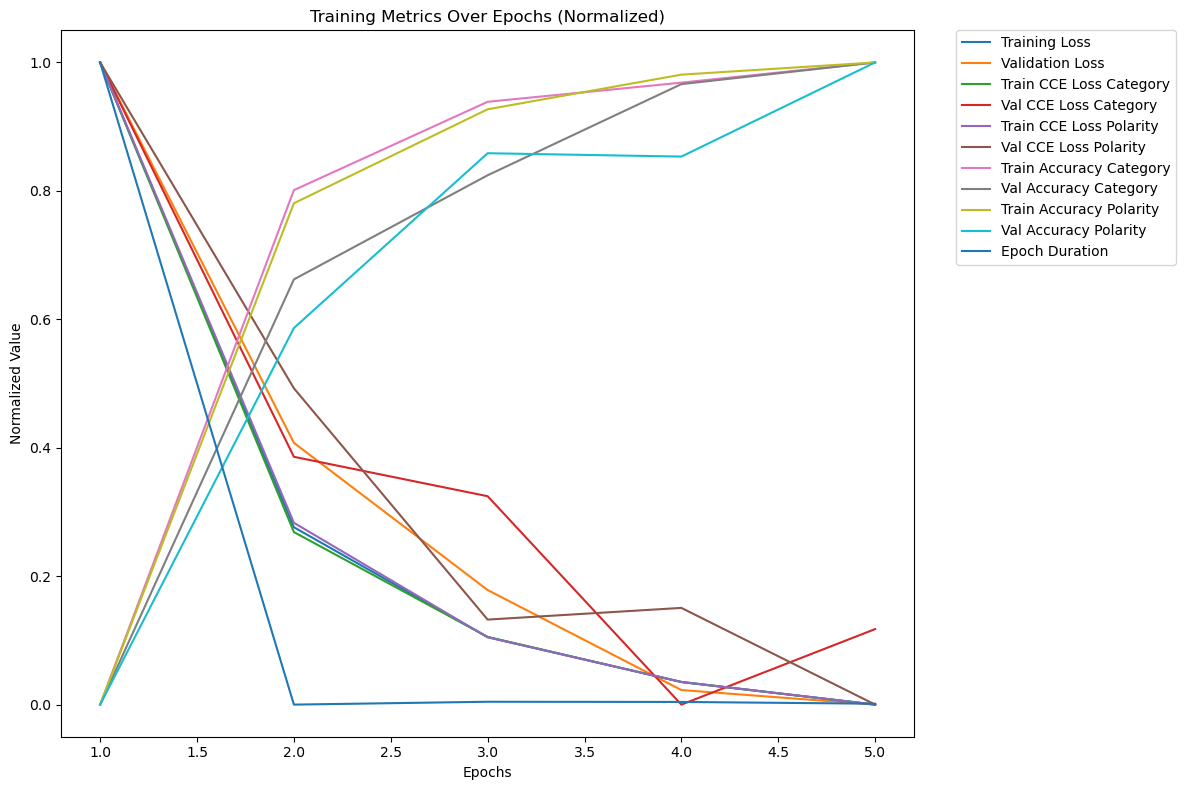

Total Training Time: 243.30 seconds


In [25]:
# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 5
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_ids,
        'attention_masks': X_train_masks
    },
    y_train_category,
    y_train_polarity
)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_ids,
        'attention_masks': X_test_masks
    },
    y_test_category,
    y_test_polarity
)).batch(batch_size)

# Import the time module
import time

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_cce_loss_polarity': [],
    'train_accuracy_category': [],
    'train_accuracy_polarity': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_cce_loss_polarity': [],
    'val_accuracy_category': [],
    'val_accuracy_polarity': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch+1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    train_accuracy_polarity.reset_states()
    val_accuracy_category.reset_states()
    val_accuracy_polarity.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category, batch_labels_polarity) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = train_step_final(
            input_ids, attention_masks, labels_category, labels_polarity)

        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        cce_loss_polarity_avg.update_state(cce_loss_pol)

        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"CCE Loss Polarity = {cce_loss_polarity_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}, "
                  f"Train Accuracy Polarity = {train_accuracy_polarity.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_cce_loss_polarity'].append(cce_loss_polarity_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())
    history['train_accuracy_polarity'].append(train_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Polarity: {cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Polarity: {train_accuracy_polarity.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_cce_loss_polarity_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        labels_category = batch_labels_category
        labels_polarity = batch_labels_polarity

        total_loss, cce_loss_cat, cce_loss_pol = test_step_final(
            input_ids, attention_masks, labels_category, labels_polarity)

        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_cce_loss_polarity_avg.update_state(cce_loss_pol)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_cce_loss_polarity'].append(val_cce_loss_polarity_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())
    history['val_accuracy_polarity'].append(val_accuracy_polarity.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Polarity: {val_cce_loss_polarity_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Polarity: {val_accuracy_polarity.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Collect all metrics to plot
    metrics_to_plot = [
        ('train_loss', 'Training Loss'),
        ('val_loss', 'Validation Loss'),
        ('train_cce_loss_category', 'Train CCE Loss Category'),
        ('val_cce_loss_category', 'Val CCE Loss Category'),
        ('train_cce_loss_polarity', 'Train CCE Loss Polarity'),
        ('val_cce_loss_polarity', 'Val CCE Loss Polarity'),
        ('train_accuracy_category', 'Train Accuracy Category'),
        ('val_accuracy_category', 'Val Accuracy Category'),
        ('train_accuracy_polarity', 'Train Accuracy Polarity'),
        ('val_accuracy_polarity', 'Val Accuracy Polarity'),
        ('epoch_time', 'Epoch Duration')
    ]

    # Normalize all metrics to 0-1 range for plotting
    normalized_metrics = {}
    for key, label in metrics_to_plot:
        data = history[key]
        min_val = min(data)
        max_val = max(data)
        if max_val - min_val == 0:
            # Avoid division by zero
            normalized_data = [0.0 for _ in data]
        else:
            normalized_data = [(x - min_val) / (max_val - min_val) for x in data]
        normalized_metrics[label] = normalized_data

    # Plot all metrics on the same plot
    plt.figure(figsize=(12, 8))

    for label, data in normalized_metrics.items():
        plt.plot(epochs, data, label=label)

    plt.title('Training Metrics Over Epochs (Normalized)')
    plt.xlabel('Epochs')
    plt.ylabel('Normalized Value')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()


# After training is complete
plot_training_history(history)

# Display total training time
print(f"Total Training Time: {total_training_time:.2f} seconds")


1/1 [==============================] - 0s 69ms/step
Test Accuracy (Category): 0.9125
Test Macro F1 Score (Category): 0.9060
Test Macro Precision (Category): 0.9132
Test Macro Recall (Category): 0.9031
Test Accuracy (Polarity): 0.9672
Test Macro F1 Score (Polarity): 0.9669
Test Macro Precision (Polarity): 0.9668
Test Macro Recall (Polarity): 0.9671


<Figure size 600x600 with 0 Axes>

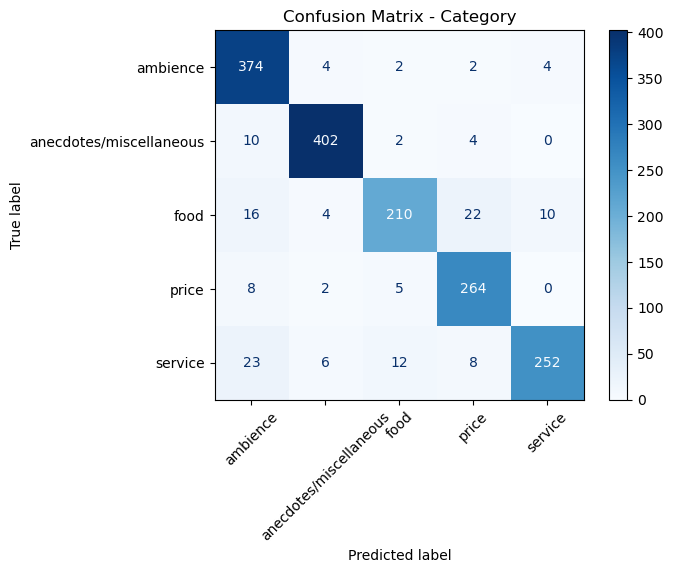

<Figure size 600x600 with 0 Axes>

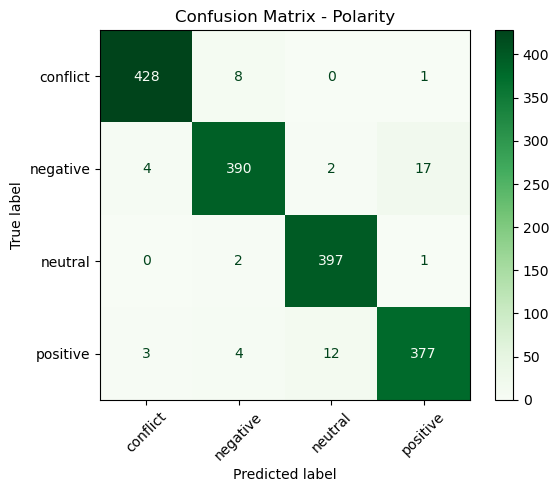

In [26]:
# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on the test set
all_predictions_category = []
all_predictions_polarity = []
all_labels_category = []
all_labels_polarity = []

for batch_inputs, batch_labels_category, batch_labels_polarity in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']

    predictions = model.predict([input_ids, attention_masks])
    predictions_category = predictions[0]
    predictions_polarity = predictions[1]

    predicted_labels_category = np.argmax(predictions_category, axis=1)
    predicted_labels_polarity = np.argmax(predictions_polarity, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_predictions_polarity.extend(predicted_labels_polarity)
    all_labels_category.extend(batch_labels_category.numpy())
    all_labels_polarity.extend(batch_labels_polarity.numpy())

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)
all_labels_polarity = np.array(all_labels_polarity)
all_predictions_polarity = np.array(all_predictions_polarity)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Calculate metrics for Polarity
accuracy_polarity = accuracy_score(all_labels_polarity, all_predictions_polarity)
f1_polarity = f1_score(all_labels_polarity, all_predictions_polarity, average='macro')
precision_polarity = precision_score(all_labels_polarity, all_predictions_polarity, average='macro')
recall_polarity = recall_score(all_labels_polarity, all_predictions_polarity, average='macro')

print(f"Test Accuracy (Polarity): {accuracy_polarity:.4f}")
print(f"Test Macro F1 Score (Polarity): {f1_polarity:.4f}")
print(f"Test Macro Precision (Polarity): {precision_polarity:.4f}")
print(f"Test Macro Recall (Polarity): {recall_polarity:.4f}")

# Plot Confusion Matrix for Category
plt.figure(figsize=(6, 6))
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Category')
plt.show()

# Plot Confusion Matrix for Polarity
plt.figure(figsize=(6, 6))
cm_polarity = confusion_matrix(all_labels_polarity, all_predictions_polarity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_polarity, display_labels=polarity_encoder.classes_)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title('Confusion Matrix - Polarity')
plt.show()
